In [1]:
#!/usr/bin/env python3
# modified based on this code: https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
"""This is a enhanced version of
https://gist.github.com/ptschandl/ef67bbaa93ec67aba2cab0a7af47700b

This script exctracts variables from all logs from tensorflow event
files ("event*"),
writes them to Pandas and finally stores them a csv-file or
pickle-file including all (readable) runs of the logging directory.

Example usage:

# create csv file from all tensorflow logs in provided directory (.)
# and write it to folder "./converted"
tflogs2pandas.py . --write-csv --no-write-pkl --o converted

# creaste csv file from tensorflow logfile only and write into
# and write it to folder "./converted"
tflogs2pandas.py tflog.hostname.12345 --write-csv --no-write-pkl --o converted
"""
import glob
import os
import pprint
import traceback

import click
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import pickle


In [2]:

# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame

    Parameters
    ----------
    path : str
        path to tensorflow log file

    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

In [3]:
def segment_df(df):
    imitation_rew = []
    real_rew = []
    critic_loss = []
    bc_loss = []
    actor_loss = []
    
    for itm in df:
        if 'rollout/ep_rew_mean' in itm:
            real_rew.append(itm)
        elif 'rollout/ep_imitation_mean' in itm:
            imitation_rew.append(itm)
        elif 'train/bc_loss' in itm:
            bc_loss.append(itm)
        elif 'train/actor_critic_loss' in itm:
            actor_loss.append(itm)
        elif 'train/critic_loss' in itm:
            critic_loss.append(itm)
            
    return imitation_rew, real_rew, critic_loss, bc_loss, actor_loss

In [4]:
def parse_data_from_boards(logdir_or_logfile):
    #logdir_or_logfile = "tmp/pwil/constrained_by_none/HalfCheetahBulletEnv-v0_subsampling_20_numdemo_5_random_0/20210218173556/events.out.tfevents.1613662564.users-MBP.82461.0"
    write_pkl = False
    write_csv = False
    out_dir = None

    pp = pprint.PrettyPrinter(indent=4)

    if os.path.isdir(logdir_or_logfile):
        # Get all event* runs from logging_dir subdirectories
        event_paths = glob.glob(os.path.join(logdir_or_logfile, "event*"))
    elif os.path.isfile(logdir_or_logfile):
        event_paths = [logdir_or_logfile]
    else:
        raise ValueError(
            "input argument {} has to be a file or a directory".format(
                logdir_or_logfile
            )
        )
    # Call & append
    if event_paths:
        # pp.pprint("Found tensorflow logs to process:")
        # pp.pprint(event_paths)
        all_logs = many_logs2pandas(event_paths)
        # pp.pprint("Head of created dataframe")
        # pp.pprint(all_logs.head())

        df_data = all_logs.values
        return segment_df(df_data)


In [5]:
def visualize_logs(all_log_data, env_names, q_types, log_type='imitation_rew', save=False):
    import baselines_plot_utils as pu
    #['Bipedal','Ant', 'Walker2D', 'Hopper', 'HalfCheetah', 'Humanoid']
    for env_n in env_names:
        for qt in q_types:
            try:
                log_data = all_log_data[qt][env_n]
                min_len = 1e20
                processed_ys = []
                for i in range(len(log_data)):
                    imit_r = log_data[i][log_type]
                    #print(np.max(imit_r[:,1].astype(np.int)))
                    if True:
                        y = pu.smooth(imit_r[:,1], radius=100)
                        x = imit_r[:,0].astype(np.int)
                        xvals = np.linspace(0, np.max(x), np.max(x))
                        yinterp = np.interp(xvals, x, y)

                        if yinterp.shape[0] < min_len:
                            min_len = yinterp.shape[0]
                        processed_ys.append(yinterp)


                #print(processed_ys)
                for i in range(len(processed_ys)):
                    #print(min_len)
                    processed_ys[i] = processed_ys[i][:min_len]

                    #plt.plot(y)
                    #plt.show()

                processed_ys = np.array(processed_ys)
                ys_mean = np.mean(processed_ys, axis=0)
                ys_std = np.std(processed_ys, axis=0)
                plt.plot(ys_mean, label=env_n+' '+qt)
                plt.fill_between(range(min_len), ys_mean+ys_std, ys_mean-ys_std, alpha=0.3)
                plt.legend()
                plt.ylabel(log_type)
                plt.xlabel('steps')
            except:
                True
        if save:
            plt.savefig(env_n+'_'+qt+'_'+log_type+'.png')
        plt.show()
            

In [6]:
env_names = ['Bipedal','Ant', 'Walker2D', 'Hopper', 'HalfCheetah', 'Humanoid']
q_types = ['none', 'upper', 'nstep_lower_upper','nstep_lower', 'DDPGfD']#'nstep_lower_upper', 'DDPGfD']

log_paths = []
log_dirs = ['../QSS/tmp/results_v1/pwil_reults_v0/'] 
log_dirs = ['../QSS/tmp/pwil_logs2/', '../QSS/tmp/pwil/'] 
for ld in log_dirs:
    tmp_pths = Path(ld).rglob('*.0')
    log_paths = log_paths + list(tmp_pths)
    
# prepare dictionary to store all logs
all_log_data = {}

for qt in q_types:
    all_log_data[qt] = {}
    for env_n in env_names:
        all_log_data[qt][env_n]=[]
        
        
# recursively globe all files
for path in log_paths:
    #print(str(path))
    for qt in q_types:
        for env_n in env_names:
            if ((env_n in str(path)) and (("by_"+qt) in str(path))) or \
               ((env_n in str(path)) and (("by_$"+qt) in str(path))):
                print(path)
                try:
                    imitation_rew, real_rew, critic_loss, bc_loss, actor_loss = parse_data_from_boards(str(path))

                    imitation_rew = np.array(imitation_rew)[:,1:].astype(np.float)
                    real_rew = np.array(real_rew)[:,1:].astype(np.float)
                    critic_loss = np.array(critic_loss)[:,1:].astype(np.float)
                    bc_loss = np.array(bc_loss)[:,1:].astype(np.float)
                    actor_loss = np.array(actor_loss)[:,1:].astype(np.float)

                    data_dict = {'imitation_rew': imitation_rew, 'real_rew': real_rew, 'critic_loss': critic_loss, \
                                 'bc_loss': bc_loss, 'actor_loss': actor_loss}

                    all_log_data[qt][env_n].append(data_dict)
                except:
                    print('tensorboard parse error...')
            #print(len(all_log_data[qt][env_n]))
print(all_log_data)

../QSS/tmp/pwil/constrained_by_$none/AntBulletEnv-v0_subsampling_20_numdemo_5_random_7/20210414151020/events.out.tfevents.1618402236.na66.tcsc-local.215717.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/AntBulletEnv-v0_subsampling_20_numdemo_5_random_5/20210414151020/events.out.tfevents.1618402236.na66.tcsc-local.215666.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/AntBulletEnv-v0_subsampling_20_numdemo_5_random_2/20210414151020/events.out.tfevents.1618402236.na66.tcsc-local.215677.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/AntBulletEnv-v0_subsampling_20_numdemo_5_random_9/20210414151020/events.out.tfevents.1618402236.na66.tcsc-local.215730.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/AntBulletEnv-v0_subsampling_20_numdemo_5_random_6/20210414151020/events.out.tfevents.1618402236.na66.tcsc-local.215726.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/AntBulletEnv-v0_subsampling_20_numdemo

../QSS/tmp/pwil/constrained_by_$none/BipedalWalker-v3_subsampling_20_numdemo_5_random_5/20210414151020/events.out.tfevents.1618402245.na54.tcsc-local.23739.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/HopperBulletEnv-v0_subsampling_20_numdemo_5_random_3/20210414151020/events.out.tfevents.1618402245.na54.tcsc-local.23883.0
../QSS/tmp/pwil/constrained_by_$none/HumanoidBulletEnv-v0_subsampling_20_numdemo_5_random_9/20210414151020/events.out.tfevents.1618402245.na54.tcsc-local.23800.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/HopperBulletEnv-v0_subsampling_20_numdemo_5_random_7/20210414151020/events.out.tfevents.1618402245.na54.tcsc-local.23915.0
../QSS/tmp/pwil/constrained_by_$none/BipedalWalker-v3_subsampling_20_numdemo_5_random_2/20210414151020/events.out.tfevents.1618402245.na54.tcsc-local.23712.0
tensorboard parse error...
../QSS/tmp/pwil/constrained_by_$none/HopperBulletEnv-v0_subsampling_20_numdemo_5_random_9/20210414151020/events.out.tfeve

In [7]:
with open('log_dict_logs2.pkl', 'wb') as handle:
    pickle.dump(all_log_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
#with open('log_dict.pkl', 'rb') as handle:
#    all_log_data = pickle.load(handle)

/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


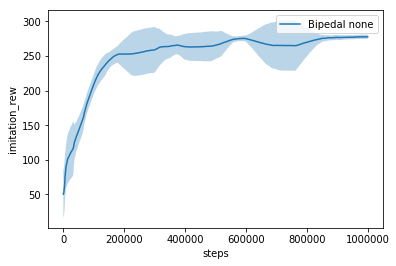

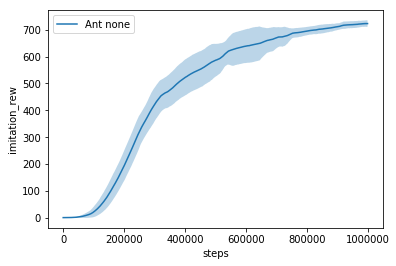

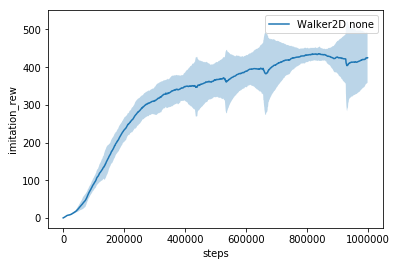

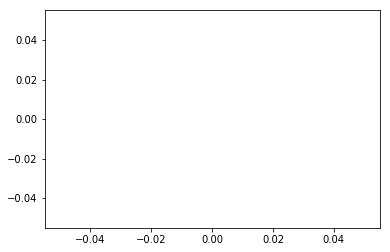

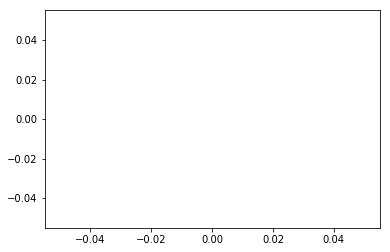

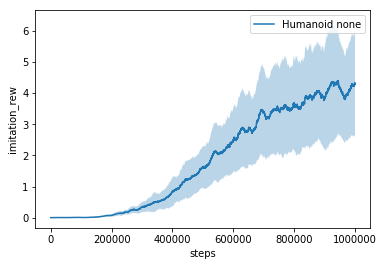

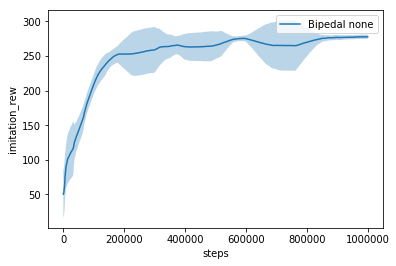

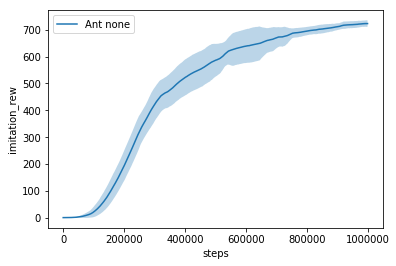

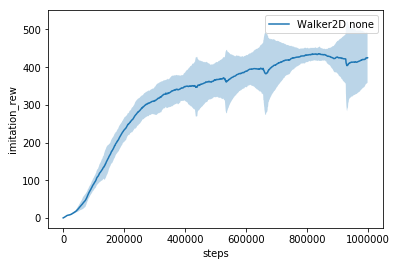

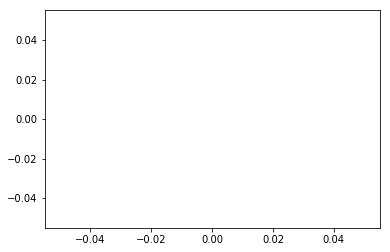

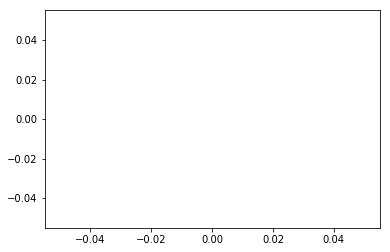

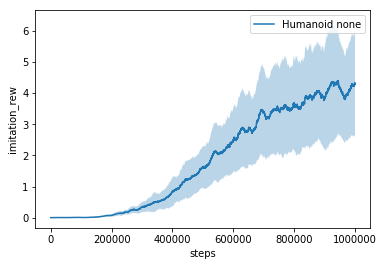

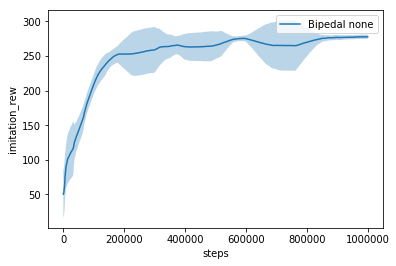

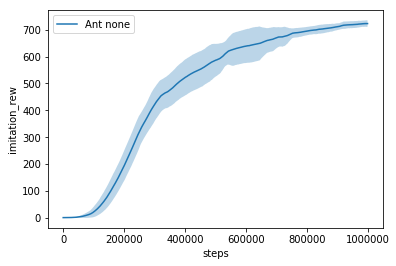

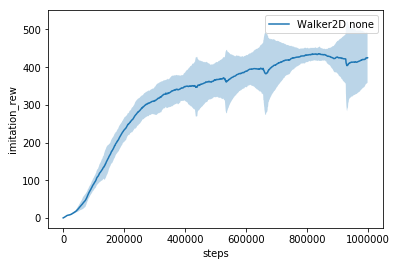

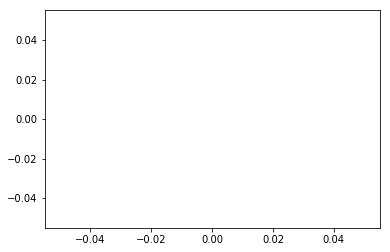

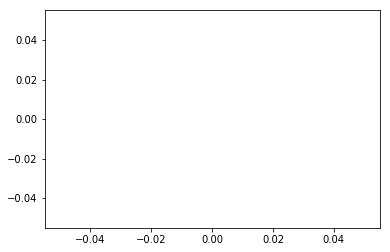

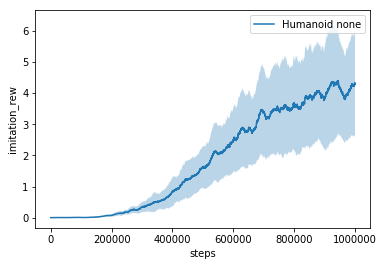

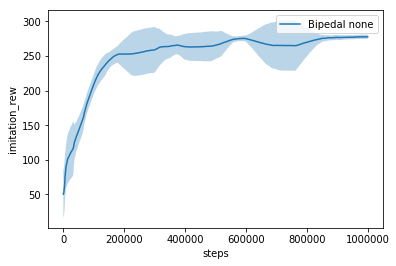

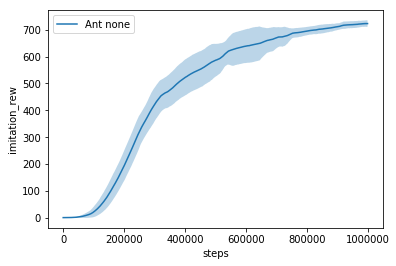

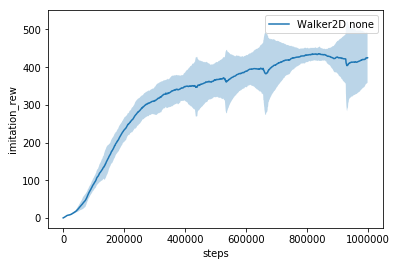

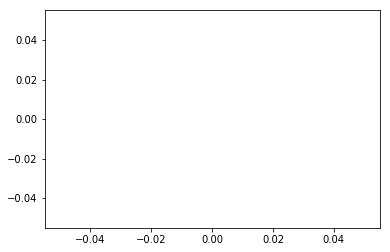

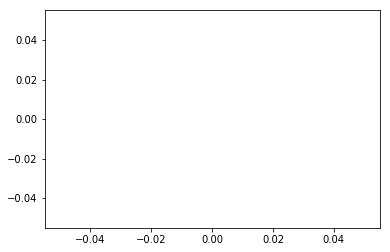

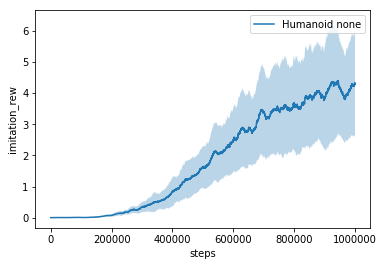

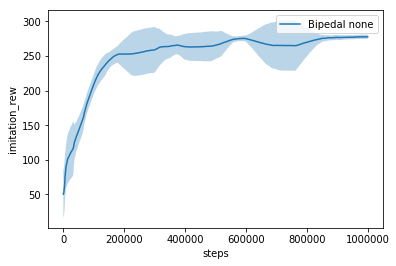

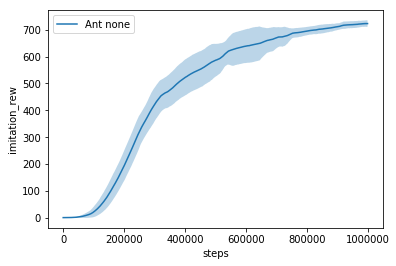

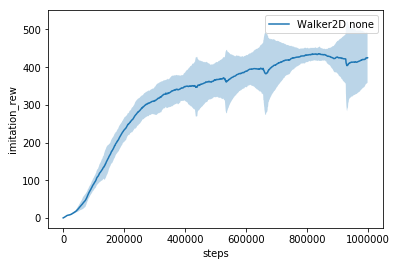

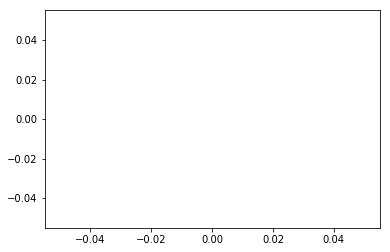

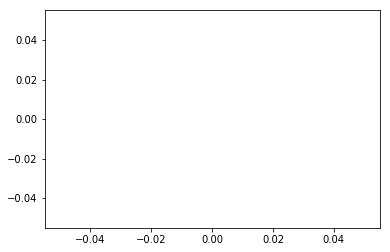

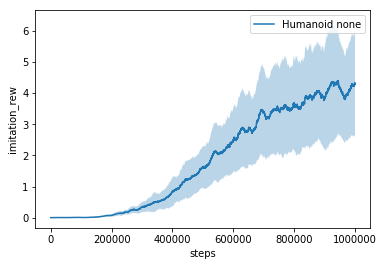

In [9]:
visualize_logs(all_log_data, env_names, [q_types[0],q_types[1],q_types[2],q_types[3], q_types[4]], log_type='imitation_rew', save=True)

visualize_logs(all_log_data, env_names, [q_types[0],q_types[1]], log_type='imitation_rew', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[2]], log_type='imitation_rew', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[3]], log_type='imitation_rew', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[4]], log_type='imitation_rew', save=True)

/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


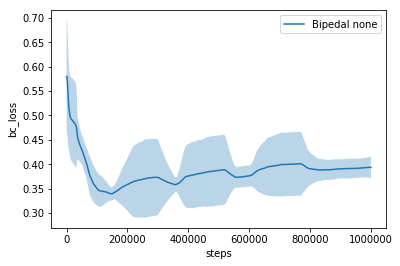

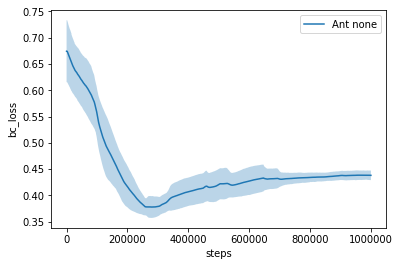

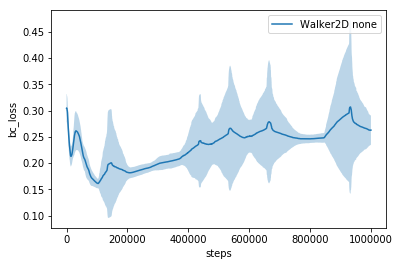

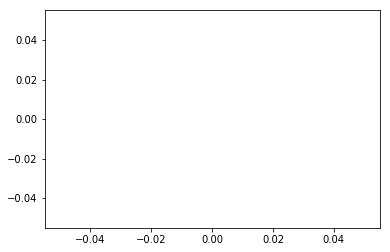

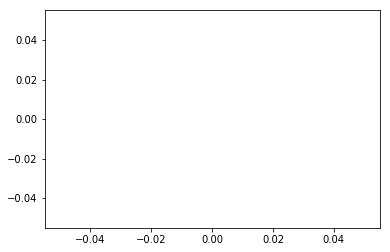

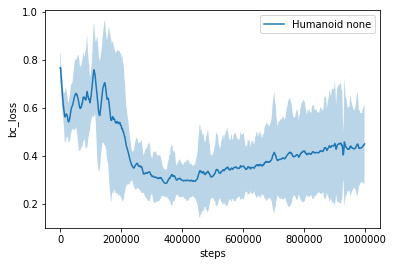

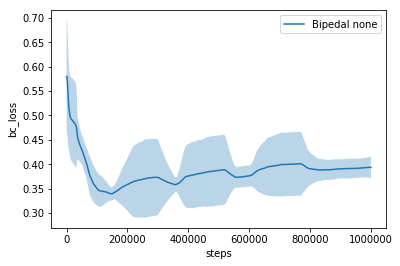

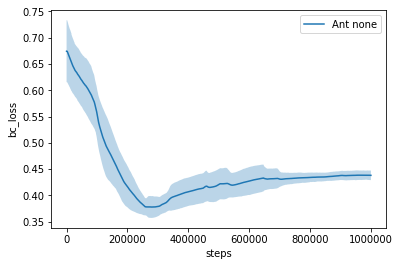

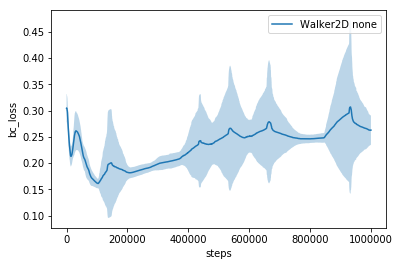

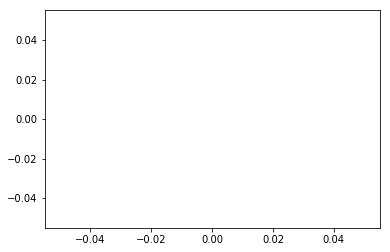

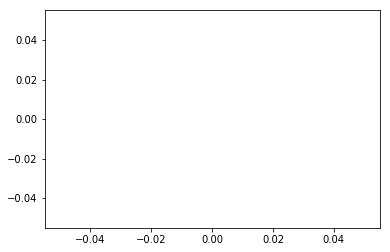

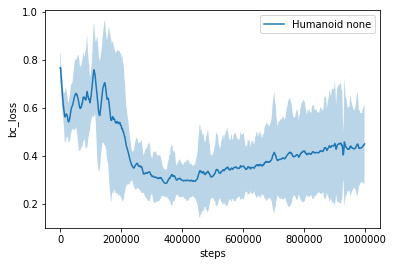

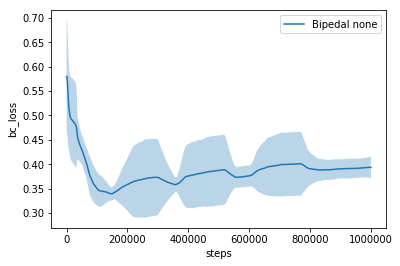

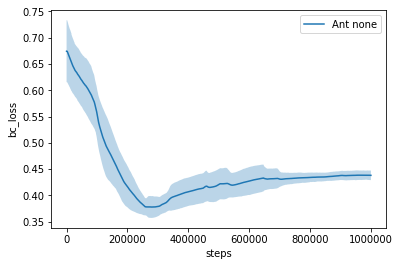

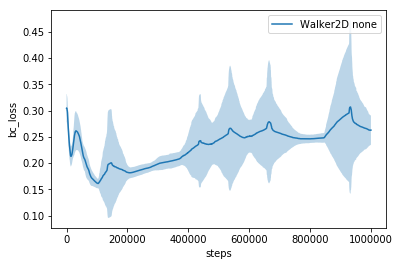

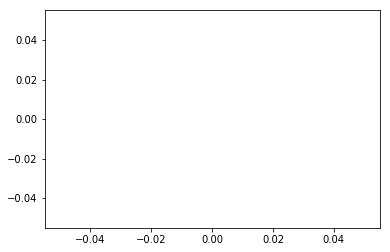

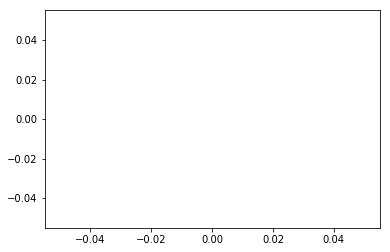

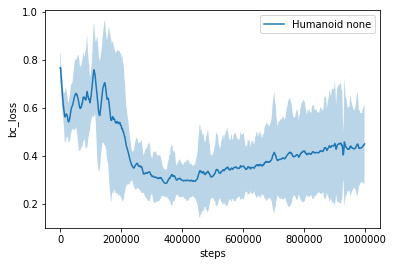

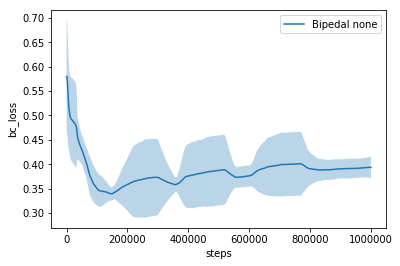

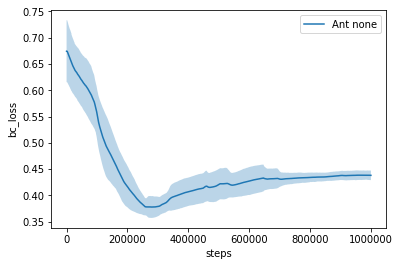

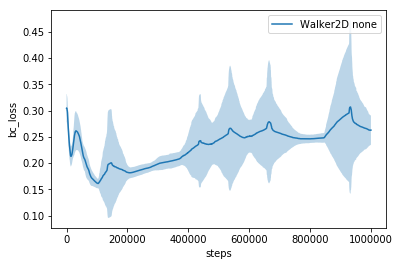

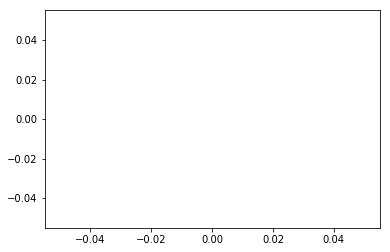

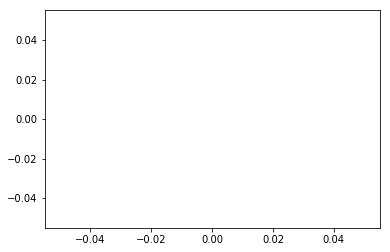

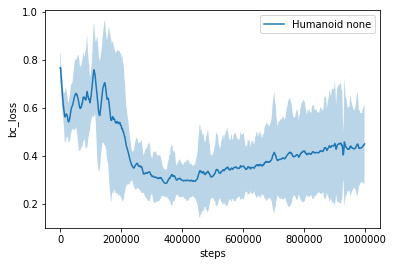

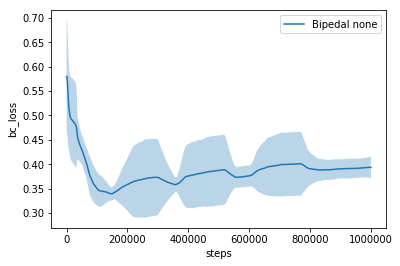

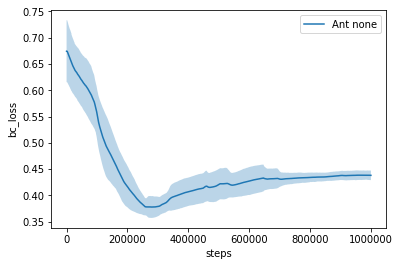

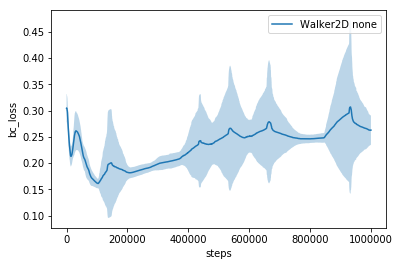

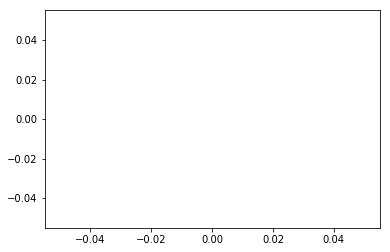

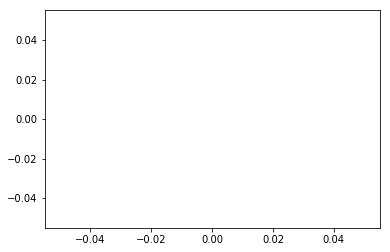

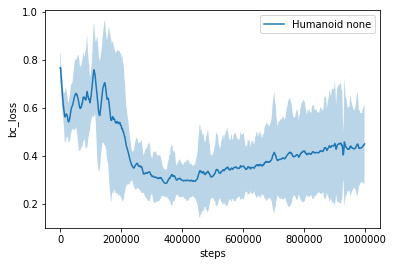

In [10]:
visualize_logs(all_log_data, env_names, [q_types[0],q_types[1],q_types[2],q_types[3]], log_type='bc_loss', save=True)

visualize_logs(all_log_data, env_names, [q_types[0],q_types[1]], log_type='bc_loss', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[2]], log_type='bc_loss', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[3]], log_type='bc_loss', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[4]], log_type='bc_loss', save=True)

/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/wenyan/.local/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


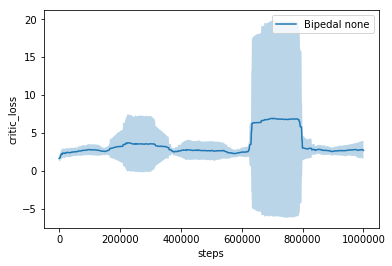

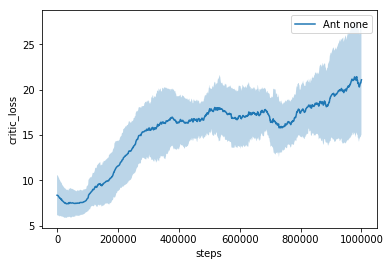

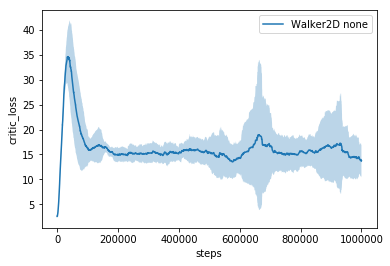

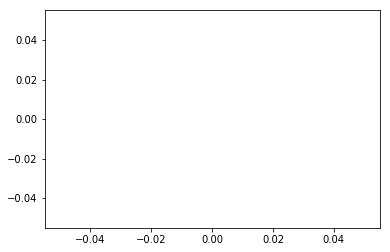

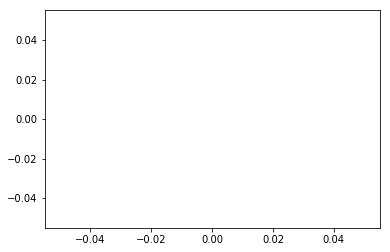

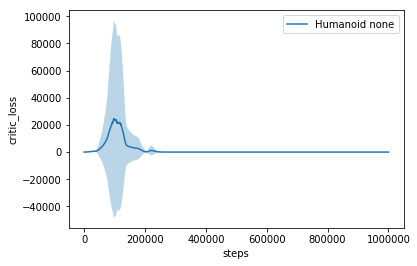

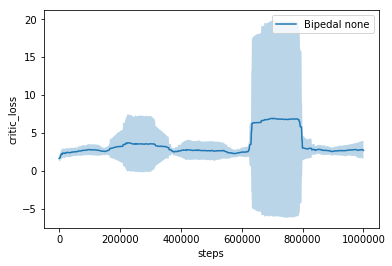

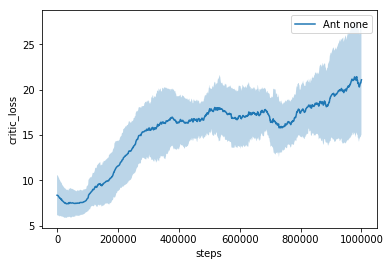

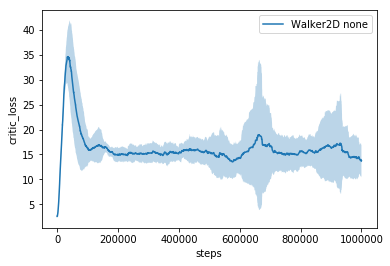

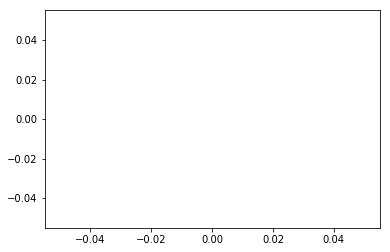

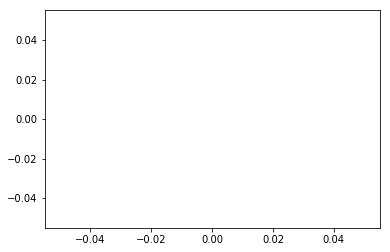

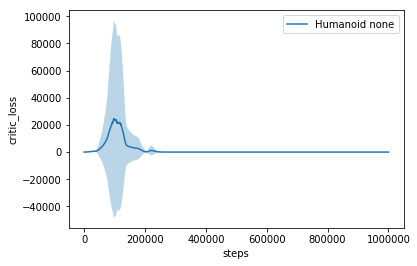

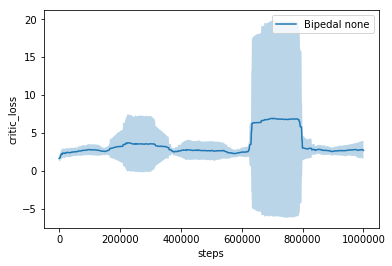

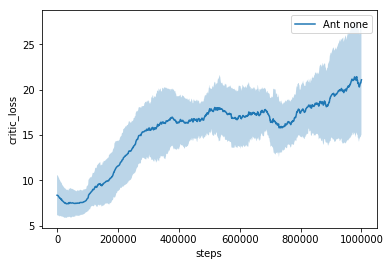

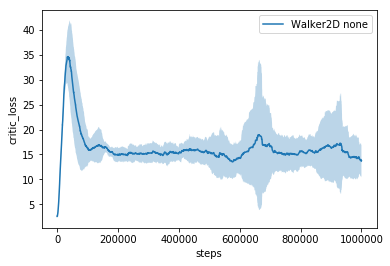

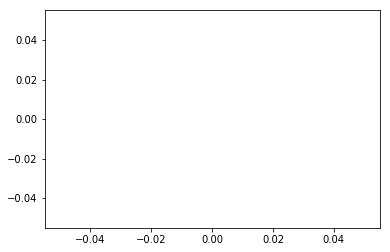

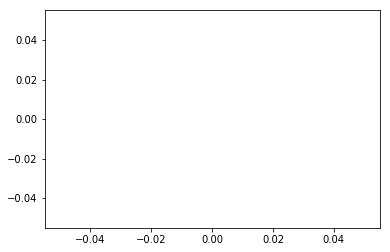

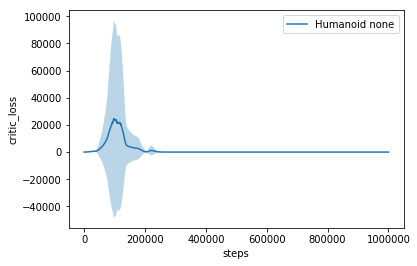

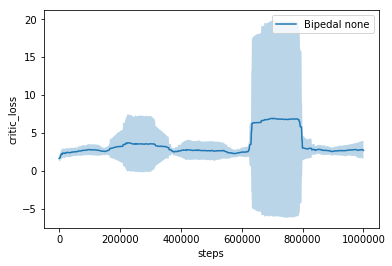

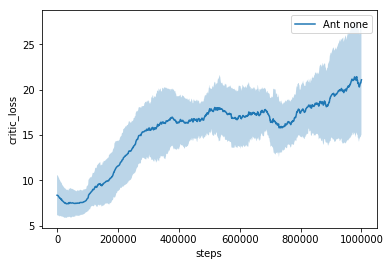

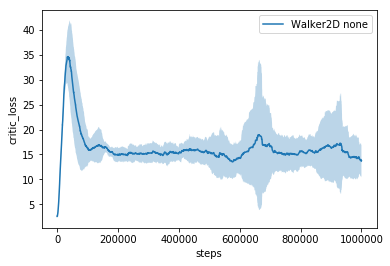

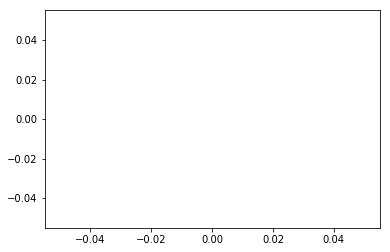

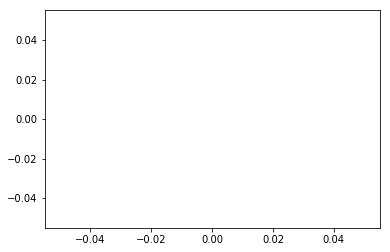

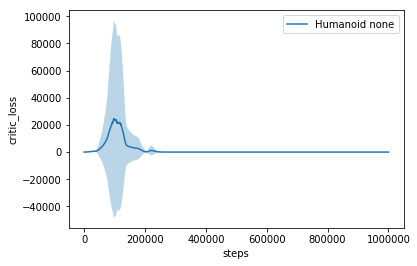

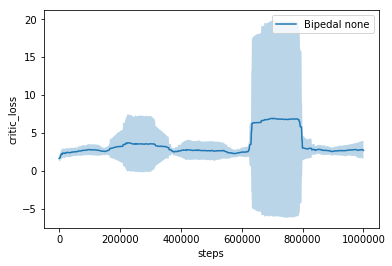

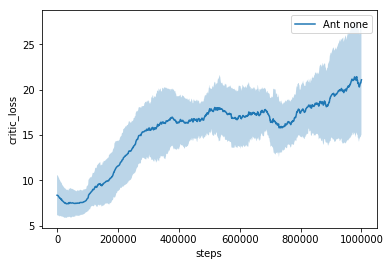

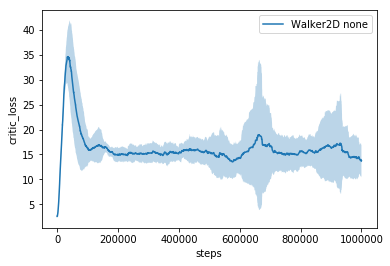

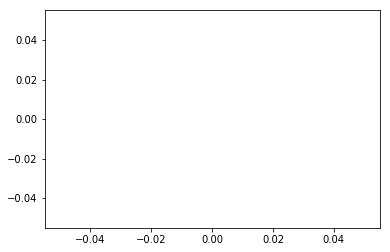

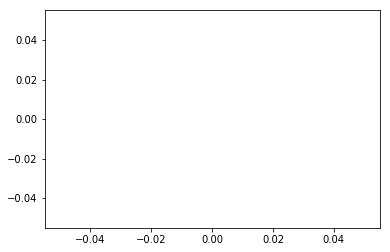

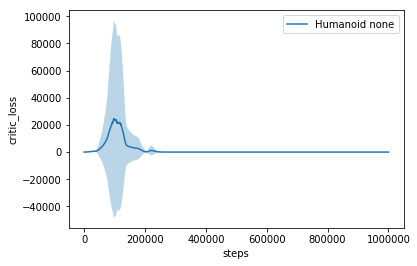

In [11]:
visualize_logs(all_log_data, env_names, q_types[:4], log_type='critic_loss', save=True)

visualize_logs(all_log_data, env_names, [q_types[0],q_types[1]], log_type='critic_loss', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[2]], log_type='critic_loss', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[3]], log_type='critic_loss', save=True)
visualize_logs(all_log_data, env_names, [q_types[0],q_types[4]], log_type='critic_loss', save=True)